In [293]:
%pylab inline
file_root = '/mnt/store1/oliverphilcox/DR12_QPM/output_rascal_nocorr/'
jackknife_file = '/mnt/store1/oliverphilcox/DR12_QPM/xi_jack/mock_1/xi_jack_corrected_n35_m10_j169_11.dat'
weight_dir = '/mnt/store1/oliverphilcox/DR12_QPM/'
m=10
n_samples = 20

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['fmin']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [284]:
# script to post-process covariance matrices for each QPM mock + produces an npz output file 
import sys,os

xi_jack = np.loadtxt(jackknife_file,skiprows=2)
n_bins = xi_jack.shape[1] # total bins
n_jack = xi_jack.shape[0] # total jackknives
n = n_bins//m # radial bins

weight_file = weight_dir+'jackknife_weights_n%d_m%d_j%d_11.dat'%(n,m,n_jack)
RR_file = weight_dir+'binned_pair_counts_n%d_m%d_j%d_11.dat'%(n,m,n_jack)

print("Loading weights file from %s"%weight_file)
weights = np.loadtxt(weight_file)[:,1:]

# First exclude any dodgy jackknife regions
good_jk=np.unique(np.where(np.isfinite(xi_jack))[0])
print("Using %d out of %d jackknives"%(len(good_jk),n_jack))
xi_jack = xi_jack[good_jk]
weights = weights[good_jk]

# Compute data covariance matrix
print("Computing data covariance matrix")
mean_xi = np.sum(xi_jack*weights,axis=0)/np.sum(weights,axis=0)
tmp = weights*(xi_jack-mean_xi)
data_cov = np.matmul(tmp.T,tmp)
denom = np.matmul(weights.T,weights)
data_cov /= (np.ones_like(denom)-denom)

print("Loading weights file from %s"%RR_file)
RR=np.loadtxt(RR_file)

Loading weights file from /mnt/store1/oliverphilcox/DR12_QPM/jackknife_weights_n35_m10_j169_11.dat
Using 169 out of 169 jackknives
Computing data covariance matrix
Loading weights file from /mnt/store1/oliverphilcox/DR12_QPM/binned_pair_counts_n35_m10_j169_11.dat


In [216]:
def load_matrices(index,jack=True):
    """Load intermediate or full covariance matrices"""
    if jack:
        cov_root = file_root+'CovMatricesJack/'
    else:
        cov_root = file_root+'CovMatricesAll/'
    c2 = np.diag(np.loadtxt(cov_root+'c2_n%d_m%d_11_%s.txt'%(n,m,index)))
    c3 = np.loadtxt(cov_root+'c3_n%d_m%d_1,11_%s.txt'%(n,m,index))
    c4 = np.loadtxt(cov_root+'c4_n%d_m%d_11,11_%s.txt'%(n,m,index))
    if jack:
        EEaA1 = np.loadtxt(cov_root+'EE1_n%d_m%d_11_%s.txt' %(n,m,index))
        EEaA2 = np.loadtxt(cov_root+'EE2_n%d_m%d_11_%s.txt' %(n,m,index))
        RRaA1 = np.loadtxt(cov_root+'RR1_n%d_m%d_11_%s.txt' %(n,m,index))
        RRaA2 = np.loadtxt(cov_root+'RR2_n%d_m%d_11_%s.txt' %(n,m,index))

        # Compute disconnected term
        w_aA1 = RRaA1/np.sum(RRaA1,axis=0)
        w_aA2 = RRaA2/np.sum(RRaA2,axis=0)
        diff1 = EEaA1-w_aA1*EEaA1.sum(axis=0)
        diff2 = EEaA2-w_aA2*EEaA2.sum(axis=0)
        RRaRRb = np.matmul(np.asmatrix(RR).T,np.asmatrix(RR))
        fact = np.ones_like(c4)-np.matmul(np.asmatrix(weights).T,np.asmatrix(weights))
        cx = np.asarray(np.matmul(diff1.T,diff2)/np.matmul(fact,RRaRRb))
        c4+=cx

    # Now symmetrize and return matrices
    return c2,0.5*(c3+c3.T),0.5*(c4+c4.T)

# Load in full jackknife theoretical matrices
print("Loading best estimate of jackknife covariance matrix")
c2,c3,c4=load_matrices('full')

# Load in partial jackknife theoretical matrices
c2s,c3s,c4s=[],[],[]
for i in range(n_samples):
    #print("Loading jackknife subsample %d of %d"%(i+1,n_samples))
    cc2,cc3,cc4=load_matrices(i)
    c2s.append(cc2)
    c3s.append(cc3)
    c4s.append(cc4)

# Compute inverted matrix
def Psi(alpha,return_neff=False):
    """Compute precision matrix from covariance matrix, removing quadratic order bias terms."""
    c_tot = c2*alpha**2.+c3*alpha+c4
    partial_cov=[]
    for i in range(n_samples):
        partial_cov.append(alpha**2.*c2s[i]+alpha*c3s[i]+c4s[i])
    tmp=0.
    for i in range(n_samples):
        c_excl_i = np.mean(partial_cov[:i]+partial_cov[i+1:],axis=0)
        tmp+=np.matmul(np.linalg.inv(c_excl_i),partial_cov[i])
    D_est=(n_samples-1.)/n_samples * (-1.*np.eye(n_bins) + tmp/n_samples)
    Psi = np.matmul(np.eye(n_bins)-D_est,np.linalg.inv(c_tot))
    if return_neff:
        slogD = np.linalg.slogdet(D_est)
        D_val = slogD[0]*np.exp(slogD[1]/n_bins)
        n_eff = (n_bins+1.)/D_val+1
        return Psi,n_eff
    return Psi

def neg_log_L1(alpha):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    Psi_alpha = Psi(alpha)
    logdet = np.linalg.slogdet(Psi_alpha)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_alpha,data_cov))-logdet[1]

Loading best estimate of jackknife covariance matrix


In [245]:
def neg_log_L1_flex_full(param):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    alpha_2,alpha_3=param
    Psi_alpha = np.linalg.inv(c2f*alpha_2**2.+c3f*alpha_3+c4f)
    logdet = np.linalg.slogdet(Psi_alpha)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_alpha,qpm_cov))-logdet[1]

In [247]:
def neg_log_L1_simple_full(alpha):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    Psi_alpha = np.linalg.inv(c2f*alpha**2.+c3f*alpha+c4f)
    logdet = np.linalg.slogdet(Psi_alpha)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_alpha,qpm_cov))-logdet[1]

In [288]:
fmin(neg_log_L1_full,1.)

Optimization terminated successfully.
         Current function value: -4455.482734
         Iterations: 10
         Function evaluations: 20


array([1.03710938])

In [287]:
fmin(neg_log_L1_simple_full,1.)

Optimization terminated successfully.
         Current function value: -4455.482943
         Iterations: 10
         Function evaluations: 20


array([1.03740234])

In [292]:
print("Loading QPM covariance matrix")
qpm_dat = np.load('/mnt/store1/oliverphilcox/qpm_900_mock_covariance.npz')
qpm_prec=qpm_dat['prec']
qpm_cov = qpm_dat['cov']

# Now optimize for shot-noise rescaling parameter alpha
print("Optimizing for the shot-noise rescaling parameter")
from scipy.optimize import fmin
alpha_best = fmin(neg_log_L1,1.)
print("Optimization complete - optimal rescaling parameter is %.6f"%alpha_best)

Loading QPM covariance matrix
Optimizing for the shot-noise rescaling parameter
Optimization terminated successfully.
         Current function value: -4562.200801
         Iterations: 10
         Function evaluations: 20
Optimization complete - optimal rescaling parameter is 1.032617


In [289]:
# Load in full theoretical matrix
c2f,c3f,c4f=load_matrices('full',jack=False)

# Load in partial full theoretical matrices
c2fs,c3fs,c4fs=[],[],[]
for i in range(n_samples):
    #print("Loading full subsample %d of %d"%(i+1,n_samples))
    cc2,cc3,cc4=load_matrices(i,jack=False)
    c2fs.append(cc2)
    c3fs.append(cc3)
    c4fs.append(cc4)

# Compute inverted matrix
def Psi_full(alpha,return_neff=False):
    """Compute precision matrix from covariance matrix, removing quadratic order bias terms."""
    cf_tot = c2f*alpha**2.+c3f*alpha+c4f
    partial_cov=[]
    for i in range(n_samples):
        partial_cov.append(alpha**2.*c2fs[i]+alpha*c3fs[i]+c4fs[i])
    tmp=0.
    for i in range(n_samples):
        c_excl_i = np.mean(partial_cov[:i]+partial_cov[i+1:],axis=0)
        tmp+=np.matmul(np.linalg.inv(c_excl_i),partial_cov[i])
    D_est=(n_samples-1.)/n_samples * (-1.*np.eye(n_bins) + tmp/n_samples)
    Psi = np.matmul(np.eye(n_bins)-D_est,np.linalg.inv(cf_tot))
    if return_neff:
        slogD = np.linalg.slogdet(D_est)
        D_val = slogD[0]*np.exp(slogD[1]/n_bins)
        n_eff = (n_bins+1.)/D_val+1
        return Psi,n_eff
    return Psi

def neg_log_L1_full(alpha):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    Psi_alpha = Psi_full(alpha)
    logdet = np.linalg.slogdet(Psi_alpha)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_alpha,qpm_cov))-logdet[1]

def neg_log_L2_full(alpha):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    cov = c2f*alpha**2.+c3f*alpha+c4f
    Psi_dat = np.linalg.inv(qpm_cov)
    logdet = np.linalg.slogdet(cov)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_dat,cov))-logdet[1]

In [290]:
from scipy.optimize import fmin
alpha_best_full_L2 = fmin(neg_log_L2_full,1.)
print("L2 Optimization complete - optimal rescaling parameter is %.6f"%alpha_best_full_L2)

Optimization terminated successfully.
         Current function value: 5333.731819
         Iterations: 13
         Function evaluations: 26
L2 Optimization complete - optimal rescaling parameter is 0.764844


In [291]:
from scipy.optimize import fmin
alpha_best_full = fmin(neg_log_L1_full,1.)
print("Optimization complete - optimal rescaling parameter is %.6f"%alpha_best_full)

Optimization terminated successfully.
         Current function value: -4455.459307
         Iterations: 10
         Function evaluations: 20
Optimization complete - optimal rescaling parameter is 1.044824


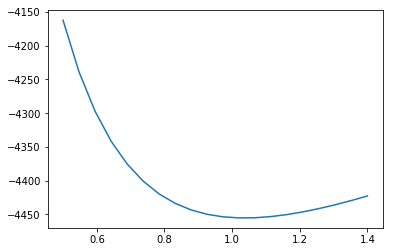

In [221]:
alphas = np.linspace(0.5,1.4,20)
likes = [neg_log_L1_full(a) for a in alphas]
plt.plot(alphas,likes)

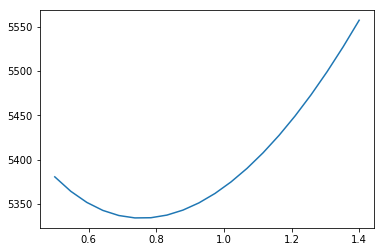

In [222]:
alphas = np.linspace(0.5,1.4,20)
likes = [neg_log_L2_full(a) for a in alphas]
plt.plot(alphas,likes)

In [223]:
def neg_log_L2_full_rascal(alpha):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    cov = c2r*alpha**2.+c3r*alpha+c4r
    Psi_dat = np.linalg.inv(qpm_cov)
    logdet = np.linalg.slogdet(cov)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_dat,cov))-logdet[1]

In [224]:
fmin(neg_log_L2_full_rascal,1.)

Optimization terminated successfully.
         Current function value: 5339.343460
         Iterations: 13
         Function evaluations: 26


array([0.79003906])

In [225]:
def neg_log_L1_full_rascal(alpha):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    Psi_alpha = np.linalg.inv(c2r*alpha**2+c3r*alpha+c4r)#Psi_full(alpha)
    logdet = np.linalg.slogdet(Psi_alpha)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_alpha,qpm_cov))-logdet[1]

fmin(neg_log_L1_full_rascal,1.)

Optimization terminated successfully.
         Current function value: -4453.495179
         Iterations: 10
         Function evaluations: 20


array([1.06894531])

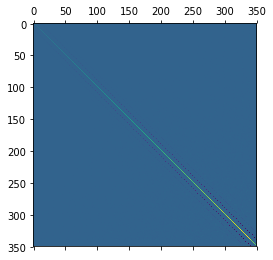

In [148]:
plt.matshow(Psi_full(0.8));

## load in Rascal matrices

In [50]:
import pickle
rascal_run = pickle.load(open('/mnt/store1/oliverphilcox/LowR__mean.pkl',"rb"),encoding='latin1')

In [56]:
c2r=rascal_run['c2'][100:,100:]
c3r=rascal_run['c3'][100:,100:]
c4r=rascal_run['c4'][100:,100:]

In [64]:
r_bins = np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/radial_binning_cov.csv').mean(axis=1)
mu_bins = np.arange(0.05,1.05,0.1)

all_r = np.asarray([r_bins[i//10] for i in range(len(c2r))])
r_matrix = np.matmul(all_r.reshape(-1,1),all_r.reshape(1,-1))

In [117]:
prec = lambda alpha: np.linalg.inv(c2r*alpha**2.+c3r*alpha+c4r)
cov = lambda alpha: c2r*alpha**2.+c3r*alpha+c4r
my_cov = lambda alpha: c2f*alpha**2.+c3f*alpha+c4f

In [95]:
def prec_plot(matrix,vmax=250):
    plt.matshow(matrix/r_matrix,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
    plt.colorbar();plt.ylim([190,150]);plt.xlim([150,190]);
def cov_plot(matrix,vmax=0.001):
    plt.matshow(matrix*r_matrix,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
    plt.colorbar();plt.ylim([190,150]);plt.xlim([150,190]);

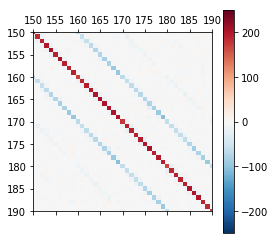

In [84]:
prec_plot(prec(0.8))

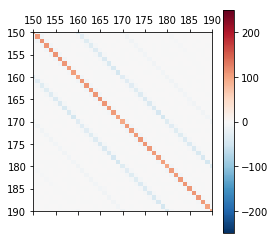

In [83]:
prec_plot(Psi_full(1.1))

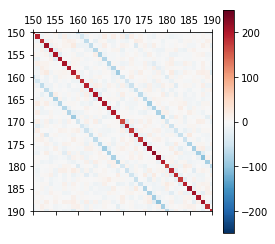

In [96]:
prec_plot(qpm_prec)

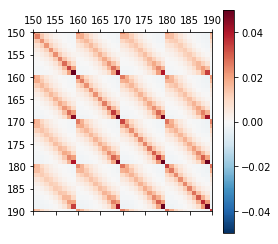

In [101]:
cov_plot(cov(1.),vmax=0.05)

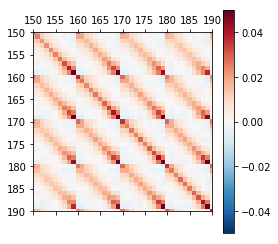

In [118]:
cov_plot(qpm_cov,vmax=0.05)

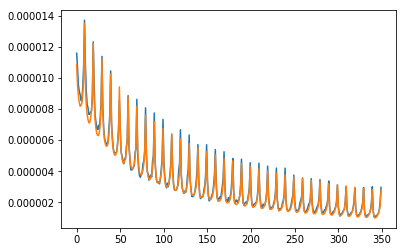

In [126]:
plt.plot(np.diag(qpm_cov))
plt.plot(np.diag(cov(1.04)))
#plt.plot(np.diag(my_cov(1.04)))

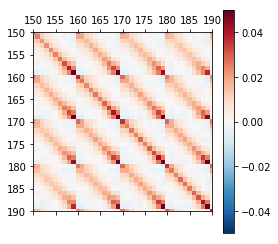

In [127]:
cov_plot(qpm_cov,vmax=0.05)

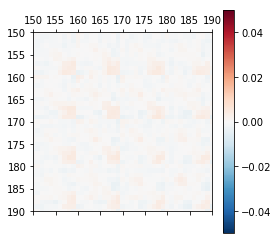

In [128]:
cov_plot(qpm_cov-my_cov(alpha_best_full),vmax=0.05)

Check precision matrices from subruns - is this a convergence issue?

In [177]:
cov_subrun = lambda alpha: c2fs[0]*alpha**2.+c3fs[0]*alpha+c4fs[0]
mean_cov = lambda alpha: np.mean(np.asarray(c2fs)*alpha**2.+np.asarray(c3fs)*alpha+np.asarray(c4fs),axis=0)
mean_prec = lambda alpha: np.linalg.inv(mean_cov(alpha))
prec_subrun = lambda alpha: np.linalg.inv(cov_subrun(alpha))

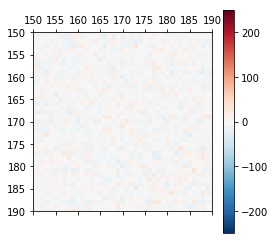

In [212]:
prec_plot(prec(0.8)-qpm_prec)

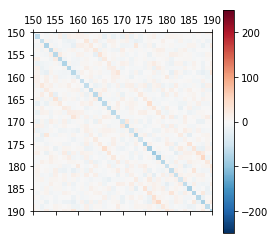

In [213]:
prec_plot(prec(1.)-qpm_prec)

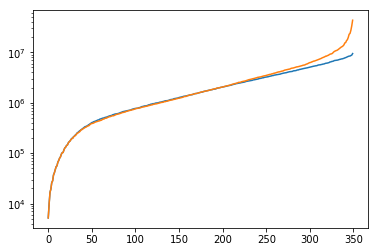

In [186]:
plt.plot(np.linalg.eigvalsh(mean_prec(0.8)))
plt.plot(np.linalg.eigvalsh(prec_subrun(0.8)))
plt.yscale('log')

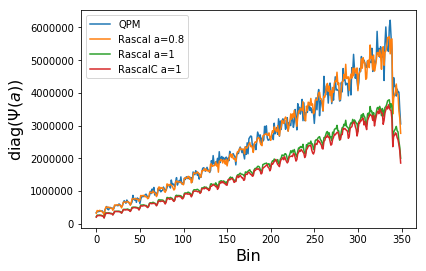

In [91]:
plt.plot(np.diag(qpm_prec),label='QPM')
plt.plot(np.diag(prec(0.8)),label='Rascal a=0.8')
plt.plot(np.diag(prec(1.)),label='Rascal a=1')
plt.plot(np.diag(Psi_full(1.)),label='RascalC a=1');
plt.legend()
plt.ylabel('$\mathrm{diag}(\Psi(a))$',fontsize=16)
plt.xlabel('Bin',fontsize=16);

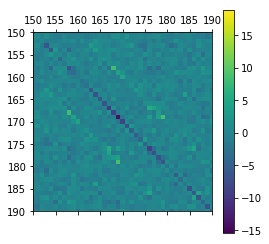

In [67]:
plt.matshow((Psi_full(1.)-prec(1.))/r_matrix);plt.colorbar();plt.ylim([190,150]);plt.xlim([150,190]);